In [7]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import math
import nltk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import mixture
%matplotlib inline

In [8]:
############ CONNECT TO THE DATABASE - OSX/Windows ############
# connection = pymysql.connect(host='localhost',
#                              user='root',
#                              password='root',#put your password for mysql server here.
#                              db='yelp_db',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

############ CONNECT TO THE DATABASE - RHEL ############
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')

data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.city,
  business.neighborhood,
  category.category
  FROM category
  inner join business on
  business.id = category.business_id
  where business.city ="Pittsburgh"
  and category.category = "Italian"
  or category.category = "Chinese"
  or category.category = "Mexican"
  or category.category = "American (New)"
  or category.category = "Mediterranean"
  or category.category = "Japanese"
  or category.category = "Thai"
  or category.category = "Indian"
  or category.category = "Middle Eastern"
  or category.category = "Greek"
  or category.category = "French"
  or category.category = "Korean"
  or category.category = "Turkish"
  or category.category = "Caribbean"
  or category.category = "Vietnamese"
  or category.category = "Latin American"
  or category.category = "Taiwanese"
  GROUP BY business.id, category.category''',connection) #.values

In [9]:
df = data[['latitude','longitude','city','category']]
df = df.loc[df['city'] == 'Pittsburgh']
df = df[['latitude','longitude','category']]
df = df.dropna(subset=['category'])
df[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())
topDf = df.copy()
categoryList = df['category'].tolist()

def topCategories(categoryList):
    n = []
    for i in categoryList:
         n += [i.split(',')]   
    count={}
    for i in n:
        for j in i:
            if j not in count:
                count[j]=1
            else:
                count[j] = count[j] +1
    return OrderedDict(sorted(count.items(), key=lambda a:a[1], reverse=True))    

def convert(j):
    for i in top:
        if(i == j):
            return(top.index(i)+1)
        
top = list(topCategories(categoryList))[0:15]
topCatNames=[]
topCatNames = top
c =[]
for i in df['category']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in top]]
topDf['category'] = c
topDf = topDf.reset_index(drop = True)
a = np.zeros(shape=(len(topDf['category']),15))
i=0
for j in c:
    for k in j:
        a[i,k-1]=1
    i+=1
top = pd.DataFrame.from_records(a)
top[['latitude','longitude']] = topDf[['latitude','longitude']]

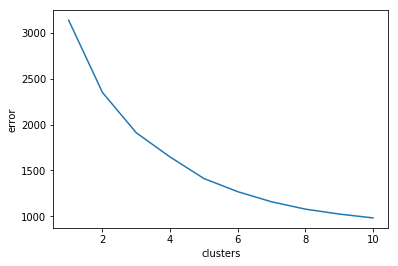

In [10]:
# evaluate the clusters
maxClusters = 10
n = maxClusters+1
error = np.zeros(n)
error[0] = 0;
for k in range(1,n):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(top)
    error[k] = kmeans.inertia_
plt.figure(1)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('clusters')
plt.ylabel('error')

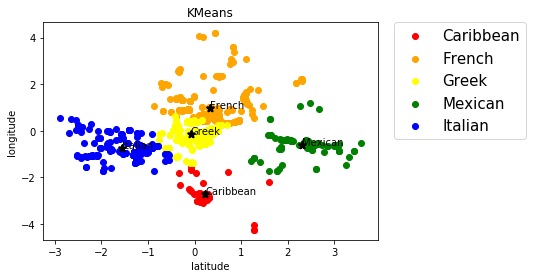

In [11]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=100) 
km = kmeans.fit_predict(top)
labels = kmeans.labels_

def createCentroids(centroids):
    y = 0  
    for i in centroids:
        plt.scatter(i[15],i[16],s=50,c='black',marker='*',linewidth=2)
        plt.annotate(labelsKm[y],xy=(i[15],i[16]))
        y+=1
    
def createScatter(clusters):
    colors = ['red','orange','yellow','green','blue']
    x = 0
    for i in clusters:
        for j in i:
            plt.scatter(top['latitude'][j],top['longitude'][j], color=colors[x])
        x=x+1
        
def labels(cluster):
    count = {}
    for i in cluster[0]:
        for j in topDf['category'][i]:
            if j not in count:
                count[j] = 1
            else:
                count[j] +=1
    return OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))

def clusterLabel(lc,topCounts):
    maxx = 0
    for key,value in lc.items():
        temp = value/topCounts[key-1]
        if(temp>maxx):
            maxx = temp
            index = key-1
    return topCatNames[index]

topCounts = list(topCategories(categoryList).values())[0:15]
labelsKm = []
km0 = np.where(km==0)
lc = labels(km0)
labelsKm.append(clusterLabel(lc, topCounts))
km1 = np.where(km==1)
lc = labels(km1)
labelsKm.append(clusterLabel(lc, topCounts))
km2 = np.where(km==2)
lc = labels(km2)
labelsKm.append(clusterLabel(lc, topCounts))
km3 = np.where(km==3)
lc = labels(km3)
labelsKm.append(clusterLabel(lc, topCounts))
km4 = np.where(km==4)
lc = labels(km4)
labelsKm.append(clusterLabel(lc, topCounts))

plt.figure(0)
clusters = [km0,km1,km2,km3,km4]
createScatter(clusters)
createCentroids(kmeans.cluster_centers_)

plt.title('KMeans')
plt.xlabel('latitude')
plt.ylabel('longitude')
ba = (1.05, 1)
legend = plt.legend([labelsKm[i] for i in range(len(labelsKm))],bbox_to_anchor=ba, loc=2, borderaxespad=0.,fontsize=15)
plt.show()

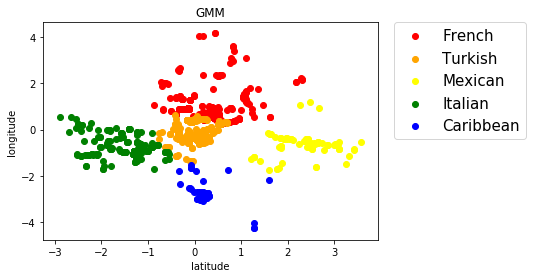

In [12]:
labelsGmm=[]
gmm = mixture.GMM(n_components=5, covariance_type='spherical')
gmm.fit(top)
gaussian = gmm.predict(top)
g0 = np.where(gaussian==0)
x= labels(g0)
labelsGmm.append(clusterLabel(x, topCounts))
g1 = np.where(gaussian==1)
x= labels(g1)
labelsGmm.append(clusterLabel(x, topCounts))
g2 = np.where(gaussian==2)
x= labels(g2)
labelsGmm.append(clusterLabel(x, topCounts))
g3 = np.where(gaussian==3)
x = labels(g3)
labelsGmm.append(clusterLabel(x, topCounts))
g4 = np.where(gaussian==4)
x = labels(g4)
labelsGmm.append(clusterLabel(x, topCounts))
clustersGmm = [g0,g1,g2,g3,g4]
plt.figure(2)
createScatter(clustersGmm)
plt.title('GMM')
plt.xlabel('latitude')
plt.ylabel('longitude')
legend = plt.legend([labelsGmm[i] for i in range(len(labelsGmm))],bbox_to_anchor=ba, loc=2, borderaxespad=0.,fontsize=15)
plt.show()